In [1]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm
from tqdm import trange

/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


In [3]:
tf.__version__

'2.0.0'

In [4]:
%matplotlib inline

In [5]:
%load_ext autoreload

%autoreload 2

In [6]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [7]:
sys.path.append(os.getcwd())

In [28]:
from src.data.train_data_utils import prepare_experiment, crossval_generator, prepare_crossval_experiment
from src.models.training_utils import generator_ratings, generator_ratings_features, mae_masked, mape_masked, mse_masked
from src.models.train_model import get_collabfiltering_model1, build_shallow_autorec_single_input, build_autorec_multi_input2, get_array

# Data prep

In [13]:
exd = prepare_experiment()

Processed: 0.0%
Processed: 0.27373261797875836%
Processed: 0.5474652359575167%
Processed: 0.8211978539362751%
Processed: 0.0%
Processed: 0.4555393586005831%
Processed: 0.9110787172011662%
Processed: 0.0%
Processed: 0.6804109682248077%


In [14]:
ytest = np.expand_dims(exd.Xraw_test.rating.to_numpy(), axis=1)

In [30]:
crossvals = list(prepare_crossval_experiment(nsplits=3))

/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Processed: 0.0%
Processed: 0.011985090547359085%
Processed: 0.02397018109471817%
Processed: 0.035955271642077256%
Processed: 0.04794036218943634%
Processed: 0.05992545273679543%
Processed: 0.07191054328415451%
Processed: 0.08389563383151359%
Processed: 0.09588072437887268%
Processed: 0.10786581492623176%
Processed: 0.11985090547359085%
Processed: 0.13183599602094995%
Processed: 0.14382108656830903%
Processed: 0.1558061771156681%
Processed: 0.16779126766302718%
Processed: 0.1797763582103863%
Processed: 0.19176144875774537%
Processed: 0.20374653930510445%
Processed: 0.21573162985246352%
Processed: 0.22771672039982263%
Processed: 0.2397018109471817%
Processed: 0.2516869014945408%
Processed: 0.2636719920418999%
Processed: 0.275657082589259%
Processed: 0.28764217313661805%
Processed: 0.29962726368397713%
Processed: 0.3116123542313362%
Processed: 0.3235974447786953%
Processed: 0.33558253532605437%
Processed: 0.3475676258734135%
Processed: 0.3595527164207726%
Processed: 0.37153780696813166%
P

KeyboardInterrupt: 

## Load experiment data

In [15]:
fpath = os.path.join(os.getcwd(), "data", "processed", "experiment")

In [17]:
with open(fpath, "wb") as ff:
    pickle.dump(exd, ff)

In [16]:
exd_old = pickle.load(open(fpath, "rb"))

In [19]:
ytest_old = np.expand_dims(exd_old.Xraw_test.rating.to_numpy(), axis=1)

In [17]:
exd.feature_names

['user_attr_Female',
 'user_attr_Male',
 'user_attr_missing',
 'model_attr_Female',
 'model_attr_Female&Male',
 'model_attr_Male',
 'brand_Apple',
 'brand_Archos',
 'brand_Bose',
 'brand_Canon',
 'brand_Cooper Cases',
 'brand_DBPOWER',
 'brand_DURAGADGET',
 'brand_EINCAR',
 'brand_EldHus',
 'brand_Etre Jeune',
 'brand_Fintie',
 'brand_Fujifilm',
 'brand_Funlux',
 'brand_Garmin',
 'brand_Gary Fong',
 'brand_Generic',
 'brand_HP',
 'brand_IRULU',
 'brand_JLAB',
 'brand_JVC',
 'brand_Jabra',
 'brand_Kensington',
 'brand_Kodak',
 'brand_Koolertron',
 'brand_LSS',
 'brand_Linksys',
 'brand_Logitech',
 'brand_Mpow',
 'brand_Neewer',
 'brand_Nikon',
 'brand_Olympus',
 'brand_Panasonic',
 'brand_Philips',
 'brand_Plemo',
 'brand_Polaroid',
 'brand_Pyle',
 'brand_Samsung',
 'brand_Savage',
 'brand_Sennheiser',
 'brand_Skullcandy',
 'brand_Sony',
 'brand_TaoTronics',
 'brand_Tiamat',
 'brand_Toshiba',
 'brand_Uniden',
 'brand_ViewSonic',
 'brand_Vivitar',
 'brand_XShields',
 'brand_ebasy',
 'bra

# Model prep

## Collaborative filtering with bias

In [55]:
dim_embed = 30
nusers = max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max())
nitems = exd.Xraw_train.item_id.max()

user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
u = krs.layers.Embedding(nusers + 1, dim_embed)(user_input)
u = krs.layers.Flatten()(u)
u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1)(user_input))

item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
i = krs.layers.Embedding(nitems + 1, dim_embed)(item_input)
i = krs.layers.Flatten()(i)
i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1)(item_input))

ui = krs.layers.Dot(axes=(1,1))([u, i])

all_features = krs.layers.Concatenate()([ui, u_bias, i_bias])
drop1 = krs.layers.Dropout(0.4)(all_features)
out = krs.layers.Dense(1)(drop1)

model_mf = krs.Model(inputs=[user_input, item_input], outputs=out)
model_mf.compile(loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked])

In [56]:
model_mf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        610050      user_input[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 30)        196680      item_input[0][0]                 
______________________________________________________________________________________________

In [57]:
x_mf = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy()
    ]
y_mf = exd.Xraw_train.rating.to_numpy()

x_val_mf = [
    exd.Xraw_valid.user_id.to_numpy(),
    exd.Xraw_valid.item_id.to_numpy()
]
y_val_mf = exd.Xraw_valid.rating.to_numpy()



In [58]:
modelcf_history = model_mf.fit(x=x_mf, y=y_mf, batch_size=32, epochs=10, validation_data=(x_val_mf, y_val_mf))

Train on 36532 samples, validate on 14697 samples
Epoch 1/10
36532/36532 [==============================] - 17s 469us/sample - loss: 14.3547 - mse_masked: 14.3529 - mae: 3.5775 - mape_masked: 0.8203 - val_loss: 9.8442 - val_mse_masked: 9.8384 - val_mae: 2.9387 - val_mape_masked: 0.6572
Epoch 2/10
36532/36532 [==============================] - 17s 473us/sample - loss: 6.2572 - mse_masked: 6.2567 - mae: 2.2512 - mape_masked: 0.5395 - val_loss: 4.4603 - val_mse_masked: 4.4572 - val_mae: 1.9348 - val_mape_masked: 0.4805
Epoch 3/10
36532/36532 [==============================] - 15s 417us/sample - loss: 2.7076 - mse_masked: 2.7076 - mae: 1.4026 - mape_masked: 0.4036 - val_loss: 2.9136 - val_mse_masked: 2.9118 - val_mae: 1.5675 - val_mape_masked: 0.4311
Epoch 4/10
36532/36532 [==============================] - 15s 416us/sample - loss: 1.6078 - mse_masked: 1.6077 - mae: 1.0405 - mape_masked: 0.3345 - val_loss: 2.4656 - val_mse_masked: 2.4646 - val_mae: 1.4479 - val_mape_masked: 0.4175
Epoch 5/

In [61]:
yhat_mf = model_mf.predict(x=[
    exd.Xraw_test.user_id.to_numpy(dtype='int32'),
    exd.Xraw_test.item_id.to_numpy(dtype='int32')
])

In [62]:
mape_masked(ytest, yhat_mf).numpy()

0.39222544

In [74]:
mask = ytest > 0
resid_mf = (ytest[mask] - yhat_mf[mask])
errors_mf = resid_mf ** 2

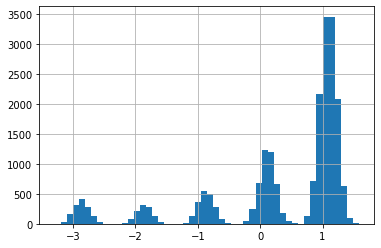

In [67]:
pd.Series((ytest[mask] - yhat_mf[mask])).hist(bins=50)

## Deep recommender

In [29]:
from sklearn.preprocessing import StandardScaler

ytrain_mu = np.mean(exd.Xraw_train.rating)
ytrain_norm = (exd.Xraw_train.rating - ytrain_mu).to_numpy()
yval_norm = (exd.Xraw_valid.rating - ytrain_mu).to_numpy()
ytest_norm = (exd.Xraw_test.rating - ytrain_mu).to_numpy()

In [30]:
exd.Xfeatures_train.shape

(36532, 87)

In [35]:
min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
min_rating, max_rating

(1.0, 5.0)

In [46]:
dim_embed = 30
nusers = max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max())
nitems = exd.Xraw_train.item_id.max()

f_input = krs.Input(shape=(exd.Xfeatures_train.shape[1],), name="features_input", dtype='float32')
f_drop = krs.layers.Dropout(rate=0.1)(f_input)
f_dense = krs.layers.Dense(32, activation='relu', kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(f_drop) #, kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(f_input)
#f_drop2 = krs.layers.Dropout(rate=0.3)(f_dense)
#f_dense2 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal())(f_drop2)


user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
u = krs.layers.Embedding(nusers + 1, dim_embed, embeddings_initializer='he_normal')(user_input)
u = krs.layers.Flatten()(u)
u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='he_normal',)(user_input))

item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
i = krs.layers.Embedding(nitems + 1, dim_embed, embeddings_initializer='he_normal',)(item_input)
i = krs.layers.Flatten()(i)
i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='he_normal',)(item_input))

ui = krs.layers.Dot(axes=(1,1))([u, i])
#ui = krs.layers.Multiply()([u, i])

#all_features = krs.layers.Concatenate(axis=1)([ui, f_dense, u_bias, i_bias])
all_features = krs.layers.Concatenate(axis=1)([ui, u_bias, i_bias, f_dense])
drop =  krs.layers.Dropout(rate=0.2)(all_features)
d1 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(drop) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(all_features)
drop2 = krs.layers.Dropout(rate=0.2)(d1)
d2 = krs.layers.Dense(8, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1(1e-4))(drop2) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(d1)
out = krs.layers.Dense(1, activation='sigmoid')(d2)
out = krs.layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

model = krs.Model(inputs=[user_input, item_input, f_input], outputs=out )

model.compile(loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked])

In [47]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        610050      user_input[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 30)        196680      item_input[0][0]                 
______________________________________________________________________________________________

In [48]:
x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
y = exd.Xraw_train.rating.to_numpy()

x_val = [
    exd.Xraw_valid.user_id.to_numpy(),
    exd.Xraw_valid.item_id.to_numpy(),
    exd.Xfeatures_valid
]
y_val = exd.Xraw_valid.rating.to_numpy()

In [49]:
es = krs.callbacks.EarlyStopping(monitor='val_mape_masked', mode='min', min_delta=0.001, patience=3)
model_history = model.fit(x=x, y=y, batch_size=16, epochs=10, validation_data=(x_val, y_val), callbacks=[es])

Train on 36532 samples, validate on 14697 samples
Epoch 1/10
36532/36532 [==============================] - 41s 1ms/sample - loss: 1.4395 - mse_masked: 1.4310 - mae: 0.9362 - mape_masked: 0.3969 - val_loss: 1.3558 - val_mse_masked: 1.3479 - val_mae: 0.9357 - val_mape_masked: 0.3748
Epoch 2/10
36532/36532 [==============================] - 35s 961us/sample - loss: 0.9620 - mse_masked: 0.9506 - mae: 0.6864 - mape_masked: 0.3020 - val_loss: 1.3490 - val_mse_masked: 1.3381 - val_mae: 0.9092 - val_mape_masked: 0.3713
Epoch 3/10
36532/36532 [==============================] - 35s 954us/sample - loss: 0.5546 - mse_masked: 0.5433 - mae: 0.4702 - mape_masked: 0.2081 - val_loss: 1.4024 - val_mse_masked: 1.3922 - val_mae: 0.9662 - val_mape_masked: 0.3715
Epoch 4/10
36532/36532 [==============================] - 36s 985us/sample - loss: 0.4059 - mse_masked: 0.3955 - mae: 0.3874 - mape_masked: 0.1636 - val_loss: 1.3521 - val_mse_masked: 1.3427 - val_mae: 0.9181 - val_mape_masked: 0.3715
Epoch 5/10
3

In [53]:
yhat = model.predict(x=[
    exd.Xraw_test.user_id.to_numpy(dtype='int32'),
    exd.Xraw_test.item_id.to_numpy(dtype='int32'),
    exd.Xfeatures_test.astype('float32')
])
#yhat_denorm = yhat + ytrain_mu

In [54]:
mape_masked(ytest, yhat).numpy() #yhat_denorm).numpy()

0.38327283

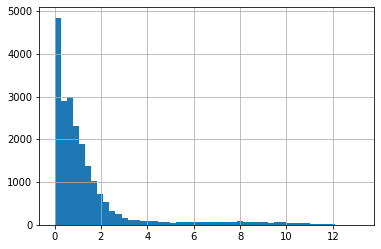

In [75]:
resid_deep = (ytest[mask] - yhat[mask])
errors_deep = resid_deep**2
pd.Series(errors_deep).hist(bins=50)

In [52]:
import gc
tf.keras.backend.clear_session()
gc.collect()

38038

# Compare two models

In [90]:
st.wilcoxon(errors_deep, errors_mf, correction=True, alternative="less")

WilcoxonResult(statistic=90159947.0, pvalue=3.578120256203746e-161)

In [87]:
st.mannwhitneyu(errors_deep, errors_mf, alternative="less")

MannwhitneyuResult(statistic=204427655.5, pvalue=7.678465422844859e-84)

In [86]:
st.ttest_ind(errors_deep, errors_mf, equal_var=False)

Ttest_indResult(statistic=-3.967816597681419, pvalue=7.265276340699381e-05)